<a href="https://colab.research.google.com/github/altz211/deeplearning/blob/main/GNN_(IceCube_2D).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install awkward
!pip install -q torch==2.5.0+cu124 torchvision torchaudio --index-url https://download.pytorch.org/whl/test/cu124
!pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.5.0+cu124.html
!pip install -q torch-geometric


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.4/879.4 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 638.7/638.7 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [106]:
import os
import numpy as np
import copy
import random
import awkward as ak
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from torch_geometric.data import Data, DataLoader, Batch
from torch_geometric.nn import DynamicEdgeConv, global_mean_pool
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

base = '/content/drive/MyDrive/Advanced Applied DL'
train_ak = ak.from_parquet(os.path.join(base, 'train.pq'))
val_ak   = ak.from_parquet(os.path.join(base, 'val.pq'))
test_ak  = ak.from_parquet(os.path.join(base, 'test.pq'))

train_list = ak.to_list(train_ak)
val_list   = ak.to_list(val_ak)
test_list  = ak.to_list(test_ak)


Mounted at /content/drive


In [22]:
def normalize_feature(arr):
    mean = arr.mean()
    std = arr.std()
    return (arr - mean) / std, mean, std

# Get normalization stats from train data
all_times = np.concatenate([np.array(ev['data'][0]) for ev in train_list])
all_xs    = np.concatenate([np.array(ev['data'][1]) for ev in train_list])
all_ys    = np.concatenate([np.array(ev['data'][2]) for ev in train_list])

_, t_mean, t_std = normalize_feature(all_times)
_, x_mean, x_std = normalize_feature(all_xs)
_, y_mean, y_std = normalize_feature(all_ys)

xpos_arr = np.array([ev['xpos'] for ev in train_list])
ypos_arr = np.array([ev['ypos'] for ev in train_list])
_, xpos_mean, xpos_std = normalize_feature(xpos_arr)
_, ypos_mean, ypos_std = normalize_feature(ypos_arr)

# Apply normalization
def normalize_event(ev):
    ev['data'][0] = ((np.array(ev['data'][0]) - t_mean) / t_std).tolist()
    ev['data'][1] = ((np.array(ev['data'][1]) - x_mean) / x_std).tolist()
    ev['data'][2] = ((np.array(ev['data'][2]) - y_mean) / y_std).tolist()
    ev['xpos'] = (ev['xpos'] - xpos_mean) / xpos_std
    ev['ypos'] = (ev['ypos'] - ypos_mean) / ypos_std

for ev in train_list + val_list + test_list:
    normalize_event(ev)


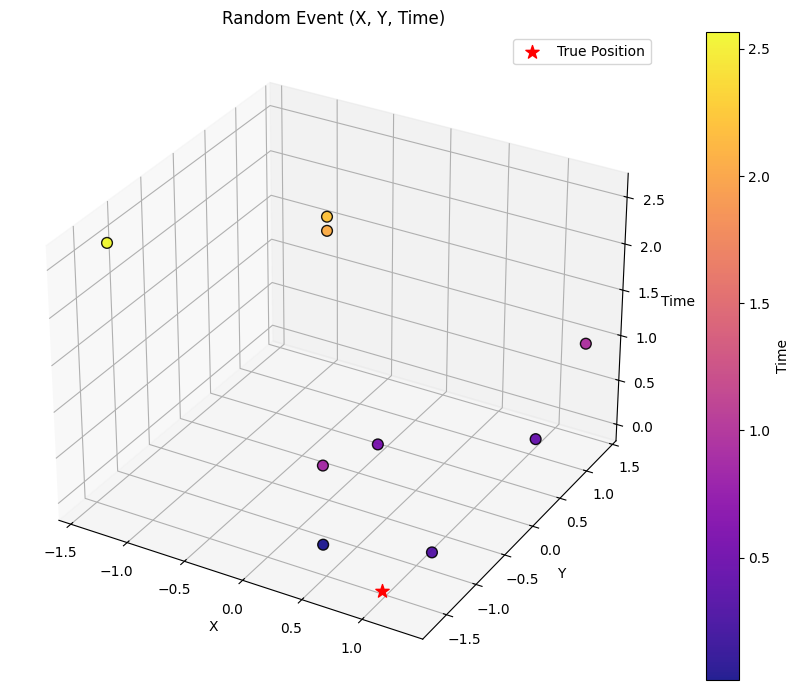

In [23]:
# Randomly pick an event from list
event = random.choice(train_list + val_list + test_list)

# Extract features
xs = np.array(event['data'][1])
ys = np.array(event['data'][2])
ts = np.array(event['data'][0])
xpos = event['xpos']
ypos = event['ypos']

# 3D Scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(xs, ys, ts, c=ts, cmap='plasma', s=60, edgecolor='k', alpha=0.9)
ax.scatter(xpos, ypos, 0, c='red', s=100, marker='*', label='True Position')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Time")
ax.set_title("Random Event (X, Y, Time)")
ax.legend()
fig.colorbar(scatter, ax=ax, label="Time")
plt.tight_layout()
plt.show()


In [24]:
def make_graph_data(dataset):
    pyg_list = []
    for ev in dataset:
        coords = np.array(ev['data'], dtype=np.float32).T
        label = torch.tensor([[ev['xpos'], ev['ypos']]], dtype=torch.float32)
        data = Data(x=torch.tensor(coords, dtype=torch.float32))
        data.y = label
        data.num_nodes = coords.shape[0]
        pyg_list.append(data)
    return pyg_list

train_data = make_graph_data(train_list)
val_data   = make_graph_data(val_list)
test_data  = make_graph_data(test_list)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)


In [25]:
class GNNModel(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=256, out_channels=2, k=8):
        super().__init__()
        self.conv1 = DynamicEdgeConv(
            nn.Sequential(
                nn.Linear(2 * in_channels, hidden_channels),
                nn.ReLU(),
                nn.Linear(hidden_channels, hidden_channels)
            ), k=k
        )
        self.conv2 = DynamicEdgeConv(
            nn.Sequential(
                nn.Linear(2 * hidden_channels, hidden_channels),
                nn.ReLU(),
                nn.Linear(hidden_channels, hidden_channels)
            ), k=k
        )
        self.lin1 = nn.Linear(hidden_channels, hidden_channels)
        self.drop = nn.Dropout(p=0.5)
        self.lin2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, batch = data.x, data.batch
        x = self.conv1(x, batch)
        x = self.conv2(x, batch)
        x = global_mean_pool(x, batch)
        x = F.relu(self.lin1(x))
        x = self.drop(x)
        return self.lin2(x)

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNModel().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
criterion = nn.MSELoss()

best_val_loss = float('inf')
patience = 10
counter = 0

for epoch in range(100):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred = model(batch)
        loss = criterion(pred, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            pred = model(batch)
            val_loss += criterion(pred, batch.y).item()

    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1:03d} | Train Loss: {total_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_gnn.pt')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break
print("Pred shape:", pred.shape)
print("Label shape:", batch.y.shape)

Epoch 001 | Train Loss: 0.2333 | Val Loss: 0.1413
Epoch 002 | Train Loss: 0.1376 | Val Loss: 0.1195
Epoch 003 | Train Loss: 0.1263 | Val Loss: 0.1051
Epoch 004 | Train Loss: 0.1132 | Val Loss: 0.1109
Epoch 005 | Train Loss: 0.1144 | Val Loss: 0.0940
Epoch 006 | Train Loss: 0.1067 | Val Loss: 0.0977
Epoch 007 | Train Loss: 0.1065 | Val Loss: 0.0941
Epoch 008 | Train Loss: 0.1006 | Val Loss: 0.0949
Epoch 009 | Train Loss: 0.0979 | Val Loss: 0.0950
Epoch 010 | Train Loss: 0.0943 | Val Loss: 0.0960
Epoch 011 | Train Loss: 0.0919 | Val Loss: 0.0904
Epoch 012 | Train Loss: 0.0920 | Val Loss: 0.0887
Epoch 013 | Train Loss: 0.0886 | Val Loss: 0.0869
Epoch 014 | Train Loss: 0.0880 | Val Loss: 0.0883
Epoch 015 | Train Loss: 0.0841 | Val Loss: 0.1079
Epoch 016 | Train Loss: 0.0804 | Val Loss: 0.0960
Epoch 017 | Train Loss: 0.0776 | Val Loss: 0.0935
Epoch 018 | Train Loss: 0.0745 | Val Loss: 0.0887
Epoch 019 | Train Loss: 0.0751 | Val Loss: 0.0916
Epoch 020 | Train Loss: 0.0600 | Val Loss: 0.0849


In [90]:
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    preds_list, labels_list = [], []

    for batch_data in loader:
        batch_data = batch_data.to(device)
        labels = batch_data.y

        preds = model(batch_data)
        loss = criterion(preds, labels)
        total_loss += loss.item() * labels.size(0)

        preds_list.append(preds.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

    preds_all = np.vstack(preds_list)
    labels_all = np.vstack(labels_list)
    mse = np.mean((preds_all - labels_all) ** 2)
    mae = np.mean(np.abs(preds_all - labels_all))
    return total_loss / len(loader.dataset), mse, mae, preds_all, labels_all


def collate_fn_gnn(batch):
    data_list = []
    for b in batch:
        coords = np.asarray(b['data'], dtype=np.float32).T
        graph = Data(x=torch.from_numpy(coords), y=torch.tensor([b['xpos'], b['ypos']], dtype=torch.float32))
        data_list.append(graph)
    return Batch.from_data_list(data_list)


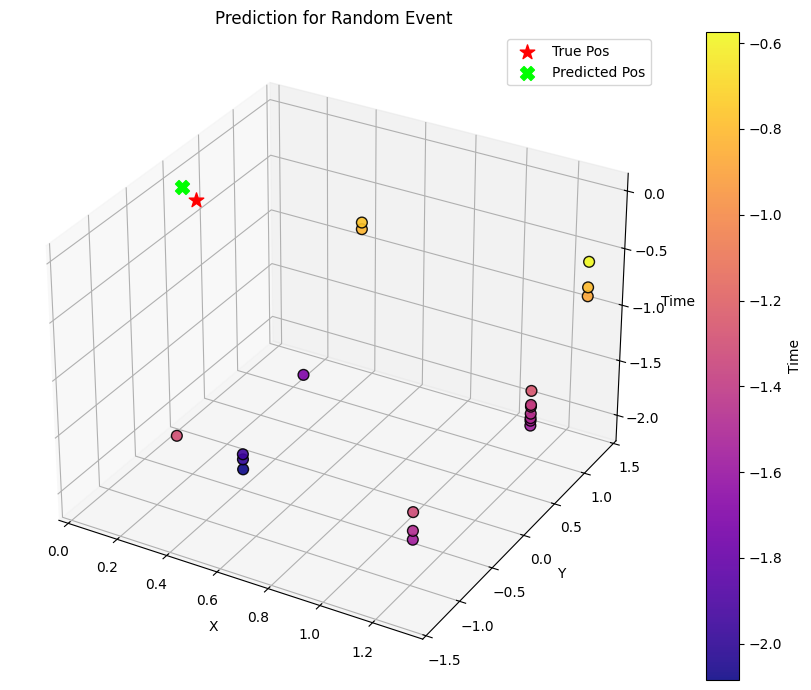

In [108]:
# Step 1: Randomly pick one normalized event
event = random.choice(test_list)

# Step 2: Prepare the event for model input
coords = np.asarray(event['data'], dtype=np.float32).T
data = Data(x=torch.from_numpy(coords))

batch_data = Batch.from_data_list([data]).to(device)

# Step 3: Make a prediction with the trained model
model.eval()
with torch.no_grad():
    pred = model(batch_data)
    pred = pred.cpu().numpy()[0]

# Step 4: Denormalize prediction and ground truth
pred_dn = np.array([
    pred[0] * xpos_std + xpos_mean,
    pred[1] * ypos_std + ypos_mean
])
true_dn = np.array([
    event['xpos'] * xpos_std + xpos_mean,
    event['ypos'] * ypos_std + ypos_mean
])

# Step 5: 3D plot (unchanged, but with prediction added)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

xs = np.array(event['data'][1])
ys = np.array(event['data'][2])
ts = np.array(event['data'][0])

scatter = ax.scatter(xs, ys, ts, c=ts, cmap='plasma', s=60, edgecolor='k', alpha=0.9)
ax.scatter(true_dn[0], true_dn[1], 0, c='red', s=120, marker='*', label='True Pos')
ax.scatter(pred_dn[0], pred_dn[1], 0, c='lime', s=100, marker='X', label='Predicted Pos')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Time")
ax.set_title("Prediction for Random Event")
ax.legend()
fig.colorbar(scatter, ax=ax, label="Time")
plt.tight_layout()
plt.show()


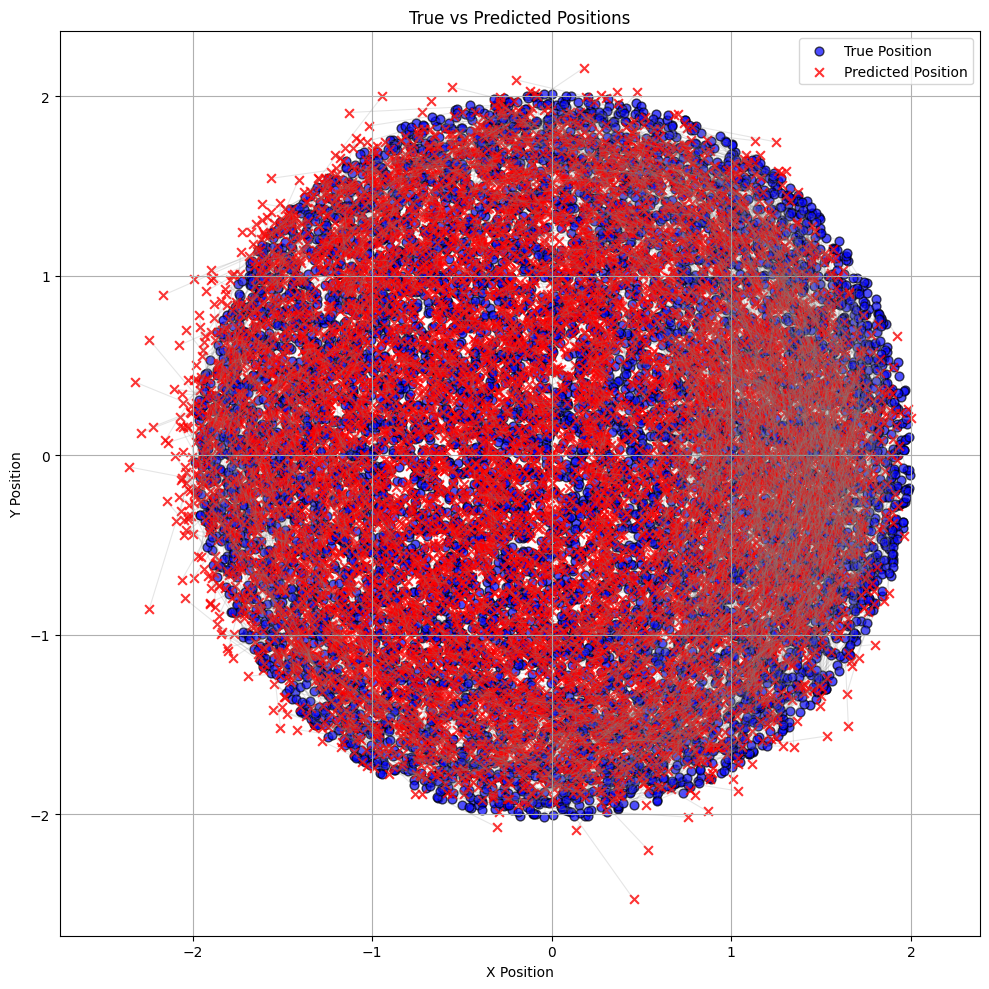

In [91]:
# Evaluate the model and prepare data
test_loss, test_mse, test_mae, preds, labs = evaluate(model, test_loader, criterion, device)

# Denormalize predictions and ground truths
preds_dn = np.column_stack([
    preds[:, 0] * xpos_std + xpos_mean,
    preds[:, 1] * ypos_std + ypos_mean
])
labs_dn = np.column_stack([
    labs[:, 0] * xpos_std + xpos_mean,
    labs[:, 1] * ypos_std + ypos_mean
])

# Compute errors
errors = preds_dn - labs_dn
error_magnitude = np.linalg.norm(errors, axis=1)

# Plot: True vs Predicted Positions with Trace Lines
plt.figure(figsize=(10, 10))
plt.scatter(labs_dn[:, 0], labs_dn[:, 1], s=40, alpha=0.7, c='blue', label='True Position', edgecolors='k')
plt.scatter(preds_dn[:, 0], preds_dn[:, 1], s=40, alpha=0.8, c='red', label='Predicted Position', marker='x')

# Draw trace lines between predicted and true positions
for true, pred in zip(labs_dn, preds_dn):
    plt.plot([true[0], pred[0]], [true[1], pred[1]], color='gray', alpha=0.2, linewidth=0.8)

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('True vs Predicted Positions')
plt.legend(loc='upper right')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()


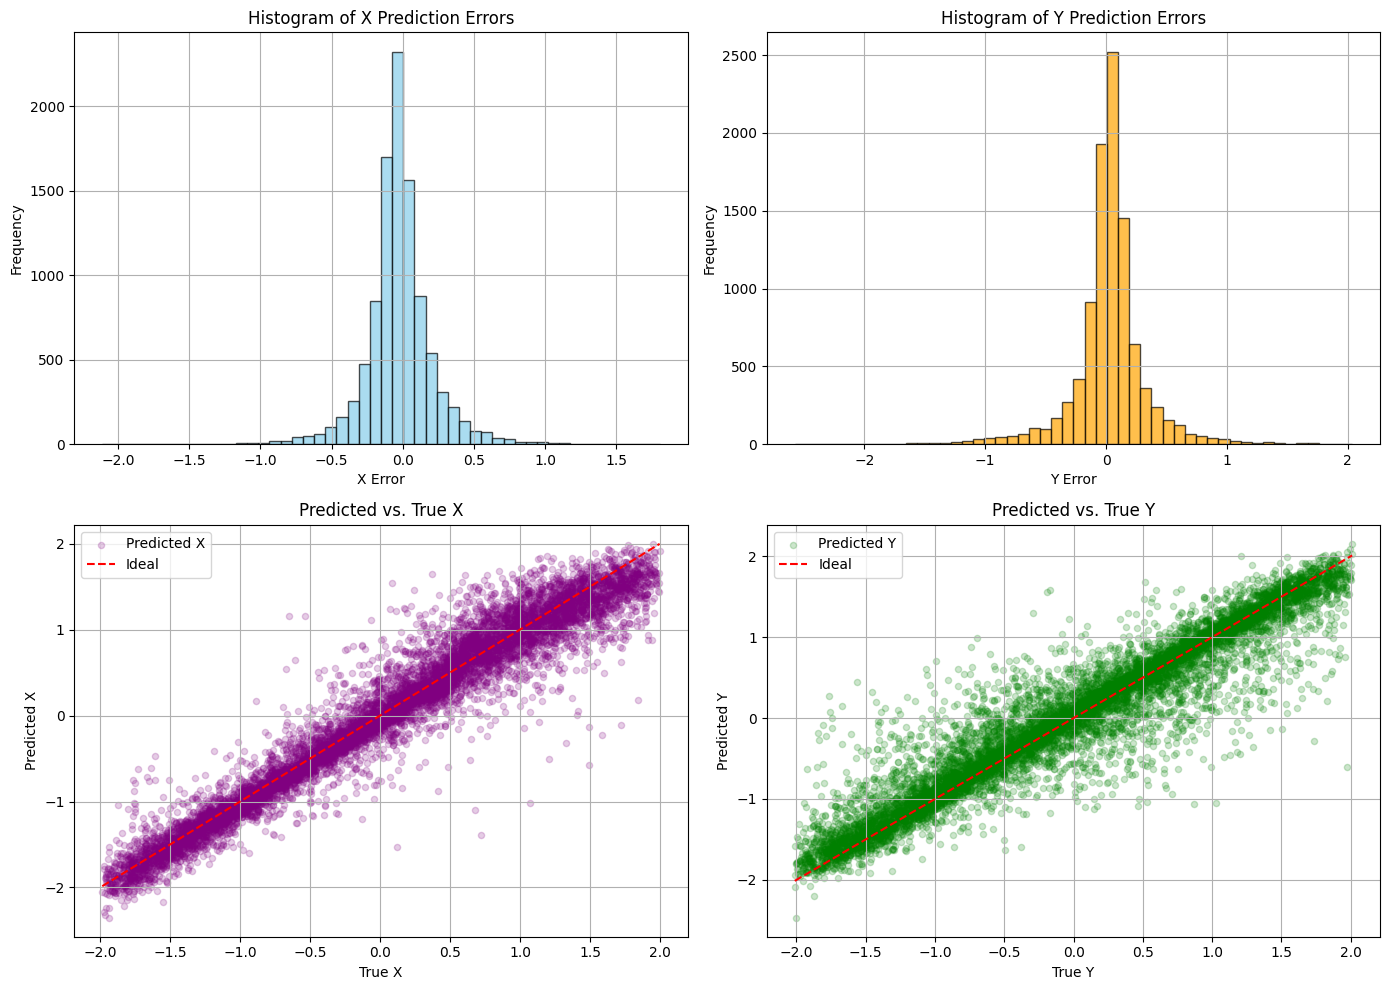

In [98]:
errors = preds_dn - labs_dn
error_magnitude = np.linalg.norm(errors, axis=1)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# X Error Histogram
axs[0, 0].hist(errors[:, 0], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axs[0, 0].set_title("Histogram of X Prediction Errors")
axs[0, 0].set_xlabel("X Error")
axs[0, 0].set_ylabel("Frequency")
axs[0, 0].grid(True)

# Y Error Histogram
axs[0, 1].hist(errors[:, 1], bins=50, alpha=0.7, color='orange', edgecolor='black')
axs[0, 1].set_title("Histogram of Y Prediction Errors")
axs[0, 1].set_xlabel("Y Error")
axs[0, 1].set_ylabel("Frequency")
axs[0, 1].grid(True)

# Predicted vs True X
axs[1, 0].scatter(labs_dn[:, 0], preds_dn[:, 0], alpha=0.2, s=20, c='purple', label='Predicted X')
axs[1, 0].plot([labs_dn[:, 0].min(), labs_dn[:, 0].max()],
               [labs_dn[:, 0].min(), labs_dn[:, 0].max()], 'r--', label='Ideal')
axs[1, 0].set_xlabel("True X")
axs[1, 0].set_ylabel("Predicted X")
axs[1, 0].set_title("Predicted vs. True X")
axs[1, 0].legend()
axs[1, 0].grid(True)

# Predicted vs True Y
axs[1, 1].scatter(labs_dn[:, 1], preds_dn[:, 1], alpha=0.2, s=20, c='green', label='Predicted Y')
axs[1, 1].plot([labs_dn[:, 1].min(), labs_dn[:, 1].max()],
               [labs_dn[:, 1].min(), labs_dn[:, 1].max()], 'r--', label='Ideal')
axs[1, 1].set_xlabel("True Y")
axs[1, 1].set_ylabel("Predicted Y")
axs[1, 1].set_title("Predicted vs. True Y")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


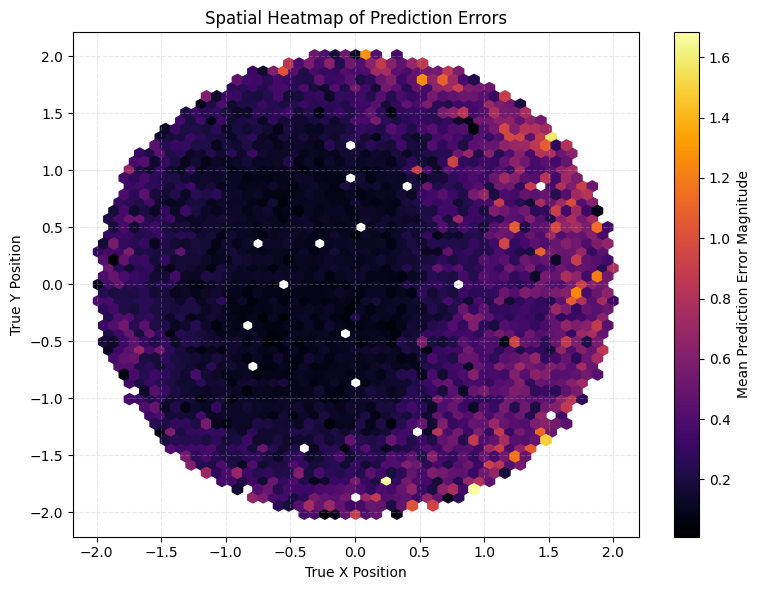

In [100]:
plt.figure(figsize=(8, 6))
hb = plt.hexbin(
    labs_dn[:, 0], labs_dn[:, 1],
    C=error_magnitude,
    gridsize=50,
    cmap='inferno',
    reduce_C_function=np.mean
)

plt.colorbar(hb, label="Mean Prediction Error Magnitude")
plt.xlabel("True X Position")
plt.ylabel("True Y Position")
plt.title("Spatial Heatmap of Prediction Errors")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()